# Como executar

Para executar esse notebook com CPU ou GPU siga os passos abaixo:

Caso esteja rodando localmente execute o comando `pip install -r requirements.txt` para download de todas as dependências necessárias e vá para o passo 4.

1. Baixe este notebook e importe para o <a href="https://colab.google/">Google Colab</a> ou acesse o link: https://colab.research.google.com/drive/1co1FJ1T7dXziRNtWJv-g1hoeUTNg31vt?usp=sharing

2. No menu superior direito do colab, onde está escrito "Conectar" ou "Ligar", clique na seta ao lado e escolha a opção "Alterar o tipo de ambiente de execução"
3. Uma janela será aberta onde você pode escolher entre utilizar CPU ou GPU. Escolha a que deseja utilizar (caso esteja em uma conta gratuita, apenas CPU e a T4 GPU estarão disponíveis). Clique em "OK" caso um pop-up apareça. Dica: GPUs são mais rápidas.


4. Para rodar este notebook, alguns arquivos são necessários. Na seção [Download do dataset](#scrollTo=lCdP6OYRRHB4&line=1&uniqifier=1) é possível fazer o download e divisão dos dados para treino e teste.

Pronto! Já está tudo preparado para execução.

<strong>OBS: Caso deseje alterar de CPU para GPU, ou vice-versa, durante a execução, a sessão será reiniciada e tudo deverá ser executado novamente.</strong>

---------------------------------------------------------------------

Para executar o treinamento e inferência do modelo execute as seguintes seções na ordem:

1. [Classe do modelo](#scrollTo=s7sAdtwdDcWw)
2. [Métricas](#scrollTo=tSJl50efcsHu)
3. [Cálculo da memória](#scrollTo=yH-vgxk7AFrP&line=1&uniqifier=1)
4. [Predição e Visualização](#scrollTo=hXrp8maoWLoh&line=1&uniqifier=1)
5. Escolher a seção referente ao ambiente de execução escolhido (T4, A100 ou CPU). Nelas temos:
  - [Treinamento](#scrollTo=gbsXBgXwNW2E)
  - [Carregamento do modelo salvo](#scrollTo=2UsObehv3NZL)
  - [Predição](#scrollTo=O16jvyEqEM7Q)
  - [Predição com bordas](#scrollTo=2xMFKN76IcM6)

OBS: para executar a predição com bordas é necessário executar as seguintes seções:
 - [Carregamento do modelo de predição de bordas](#scrollTo=fIxoFjozVOVy&line=1&uniqifier=1)
 - [Carregamento do modelo de segmentação com bordas](#scrollTo=ufGYDZxXVWTR&line=1&uniqifier=1)

In [ ]:
!pip install psutil


## Considerações para deploy
Apesar de não ter sido feito um deploy da solução, o código foi desenvolvido pensando em prepará-lo para um possível deploy. Os pontos considerados foram:

|Etapa | Importância | Aplicação |
|-----| ------| ------ |
| 1. Encapsulamento | Assegura que a aplicação e todas as suas dependências sejam isoladas, portáveis, seguras e fáceis de gerenciar. Também promove consistência e facilita a automação. | Cada função ou classe é responsável por uma funcionalidade específica. O que acontece em cada uma não impacta o restante do código. |
| 2. Qualidade do código| É avaliada por sua legibilidade, manutenibilidade, eficiência, confiabilidade, segurança, adesão a padrões e boas práticas, e simplicidade. A adoção de boas práticas de codificação facilita a manutenção e entendimento do código.| Indentação consistente, nome de variáveis e funções significativas e documentação no formato docstring garantem a legibilidade do código. |
|3. Reutilização de código e de funções | Promove eficiência e manutenção, evitando duplicação e facilitando atualizações no desenvolvimento de software. | Tudo que é utilizado mais de uma vez foi modularizado para facilitar a reutilização e o uso de parâmetros garante uma dinamicidade ao uso, podendo ser facilmente adaptado onde for necessário. |
| 4. Documentação completa  | Garante que todos os aspectos do sistema sejam compreensíveis e acessíveis, facilitando o uso, manutenção e evolução do software. | Documentação detalhada de parâmetros, funcionalidades e retornos de cada método e classe para facilitar o entendimento. |
| 5. Modularidade | Divide um sistema em partes independentes e específicas, facilitando a manutenção, reutilização, escalabilidade, flexibilidade, compreensibilidade, colaboração e testabilidade do sistema. | Cada funcionalidade do sistema foi modularizada em métodos próprios. |
| 6. Gerenciamento de dependências | Garantir que a mesma versão de bibliotecas externas sejam usadas por todos para que não haja problemas na aplicação. | Foi criado um arquivo "requirements.txt" com a lista de todas as dependências necessárias e suas respectivas versões. |
| 7. Manuseio de erros. | Garantir que a aplicação possa lidar com falhas de maneira controlada e previsível. Boas práticas no manuseio de erros aumentam a robustez, a usabilidade e a manutenção do software. | Para cada método foi adicionado uma mensagem de erro amigável utilizando blocos `try-catch`. |

Todos esses pontos foram levados em consideração para garantir que a aplicação seja de fácil entendimento, reproduzível e adaptável da melhor maneira possível, podendo ser usada para diferentes casos de uso. Cada célula de código deste notebook possui uma explicação específica de como esses pontos foram considerados.

Gerenciamento de dependências:
- Utilizamos um arquivo requirements.txt para listar todas as bibliotecas e dependências necessárias para o projeto, garantindo que todos os colaboradores usem as mesmas versões. Abaixo está a importação delas.

Configurações e variáveis de ambiente:
- Não tivemos nenhum código que envolva este tópico

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle
import pandas as pd
import tensorflow as tf
from keras import Input
from keras.utils import Sequence
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Conv2DTranspose, concatenate, Dropout
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import time
import gdown
import psutil
from tabulate import tabulate
from typing import Dict, Union, List

In [ ]:
# caso tenha os arquivos em seu drive execute esta célula
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preparação final dos dados
As células abaixo redimensionam as imagens nos shapes desejados para o modelo.

Caso tenha subido os arquivos diretamente no colab, clique nos três pontos que aparecem ao passar o cursor em cima do arquivo e selecione "Copiar caminho". No caso do Drive, busque os arquivos na pasta "drive" e faça o mesmo procedimento descrito anteriormente. Substitua os caminhos das células abaixo conforme necessário.

<strong> OBS: Atente-se aos arquivos que estão sendo chamados

Encapsulamento:
- A função load_data encapsula a lógica de carregamento e processamento de dados de imagens e máscaras, mantendo o código modular e reutilizável.

Documentação completa:
- A função está evidamente documentada utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - A função está organizada de forma modular, permitindo que a lógica de carregamento de dados seja facilmente mantida e atualizada.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- A função load_data é projetada para ser reutilizável em diferentes contextos de pré-processamento de dados, podendo aceitar diferentes dataframes por meio de parâmetros.

Manuseio de erros:
 - Caso haja um erro na execução, uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

### Download do dataset

In [ ]:
def load_data(img_target_shape, mask_target_shape, imgs_path, mask_paths):
  """
    Carrega as imagens e máscaras de um arquivo pickle e redimensiona as imagens e máscaras para o tamanho desejado

    Args:
      img_target_shape: tuple, tamanho da imagem de entrada
      mask_target_shape: tuple, tamanho da máscara de entrada

    Returns:
      X: numpy array, imagens de entrada
      Y: numpy array, máscaras representando as classes
  """
  try:
    imgs = pd.read_pickle(imgs_path)
    masks = pd.read_pickle(mask_paths)

    imgs = imgs.sort_values(by="name").reset_index(drop=True)
    masks = masks.sort_values(by="name").reset_index(drop=True)

    shuffled_indices = np.random.permutation(imgs.index)

    # Embaralha as imagens e máscaras para evitar imagens de um mesmo local juntas
    imgs_shuffled = imgs.loc[shuffled_indices].reset_index(drop=True)
    masks_shuffled = masks.loc[shuffled_indices].reset_index(drop=True)

    imgs_arr = []
    masks_arr = []

    for index, row in imgs_shuffled.iterrows():
      imgs_arr.append(row['values'])
      masks_arr.append(masks_shuffled['values'].iloc[index])

    n = len(imgs_arr)
    img_height, img_width, img_channel = img_target_shape
    mask_height, mask_width, mask_channel = mask_target_shape

    X = np.zeros((n, img_height, img_width, img_channel), dtype=np.float32)
    Y = np.zeros((n, mask_height,mask_width,mask_channel), dtype=np.int32)

    for index in range(len(imgs_arr)):
      single_img = Image.fromarray(np.uint8(255*imgs_arr[index]), 'RGB')
      single_img = single_img.resize((img_height, img_width))
      single_img = np.reshape(single_img,(img_height,img_width,img_channel))
      X[index] = single_img / 255

      single_mask = Image.fromarray(masks_arr[index]).convert('L')
      single_mask = single_mask.resize((mask_height, mask_width))
      single_mask = np.array(single_mask).reshape((mask_height,mask_width,mask_channel))
      Y[index] = single_mask

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
    return X_train, X_test, y_train, y_test

  except Exception as e:
        print(f"Erro ao carregar os dados: {e}")
        raise

In [ ]:
# file_id_images = '1zvX3B4sHcyIvr6hmAd3kjImWoSr1Ln8g'
# file_id_masks = '1--Bx8QGlYpTzOTunTR6Jyj8lpDl3MPhK'

# download_url_images = f"https://drive.google.com/uc?id={file_id_images}"
# download_url_masks = f"https://drive.google.com/uc?id={file_id_masks}"

# gdown.download(download_url_images, 'images.pkl', quiet=False)
# gdown.download(download_url_masks, 'masks.pkl', quiet=False)

X_train, X_test, y_train, y_test = load_data((208, 208, 3), (208, 208, 1), "/content/drive/MyDrive/generated data/loaded_df/images.pkl", "/content/drive/MyDrive/generated data/loaded_df/masks.pkl")

print("X shape:", X_train.shape)
print("X dtype:", X_train.dtype)
print("Y shape:", y_train.shape)
print("Y dtype:", y_train.dtype)

X shape: (6300, 208, 208, 3)
X dtype: float32
Y shape: (6300, 208, 208, 1)
Y dtype: int32


In [ ]:
y_train[0]

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=int32)

In [ ]:
for el in y_train:
  if np.unique(el) != 0:
     print(np.unique(el))

### Criação de máscaras apenas com as bordas

Para tentar melhorar a segmentação das bordas foi feito um teste de utilizar um quarto canal nas imagens com a informação das bordas. A célula abaixo cria máscaras referentes as bordas utilizando a função Canny do cv2, um algoritmo de detecção de bordas, nas máscaras originais.

In [ ]:
import cv2
def highlight_edges_on_image(real_mask):
    """
    Cria máscaras apenas com as bordas utilizando como base as máscaras originais. Assim, a detcção é mais precisa.

    Args:
      real_mask (np.array): a máscara base da imagem

    Returns:
      np.array: a máscara referente apenas as bordas normalizada
    """
    real_mask = real_mask.squeeze()

    # Normaliza a máscara para um canal único de 8-bit se necessário
    if real_mask.dtype != np.uint8:
        real_mask = cv2.normalize(real_mask, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Detecta as bordas utilizando o algoritmo Canny
    edges = cv2.Canny(real_mask, 100, 200)

    return edges / 255

# cria um conjunto de treino e validação com essas máscaras de bordas
y_train_edge = np.zeros(y_train.shape)
y_test_edge = np.zeros(y_test.shape)

for i in range(len(y_train)):
  real_mask = y_train[i]

  highlighted_image = highlight_edges_on_image(real_mask)
  highlighted_image = np.reshape(highlighted_image,(y_train.shape[1],y_train.shape[2],y_train.shape[3]))
  y_train_edge[i] = highlighted_image

for i in range(len(y_test)):
  real_mask = y_test[i]

  highlighted_image = highlight_edges_on_image(real_mask)
  highlighted_image = np.reshape(highlighted_image,(y_test.shape[1],y_test.shape[2],y_test.shape[3]))
  y_test_edge[i] = highlighted_image

### Gerador de Batch

#### Classe gerador de batch

Encapsulamento:
- A classe GeradorSequencias encapsula a lógica de geração de lotes (batches) de dados. Isso ajuda a manter a lógica organizada e modular.

Documentação completa:
- A classe e seus métodos estão devidamente documentadas utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - A classe está organizada de forma modular, permitindo que seja facilmente testada e mantida.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- A classe GeradorSequencias contém métodos que podem ser reutilizados em diferentes partes do código, como __len__ e __getitem__. O uso de parâmetros torna-as mais dinâmicas.

Manuseio de erros:
 - Caso haja um erro na execução, uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging.

In [ ]:
class GeradorSequencias(Sequence):
  """
  Inicializa o gerador de sequências com as entradas, saídas e o tamanho do lote.

  Args:
  entradas (array): Dados de entrada.
  saidas (array): Dados de saída correspondentes.
  batch_size (int): Tamanho do lote.
  """
  def __init__(self, entradas, saidas, batch_size):
    self.entradas = entradas
    self.saidas = saidas
    self.batch_size = batch_size

  def __len__(self): #quantidade de lotes
    return len(self.entradas) // self.batch_size

  def __getitem__(self, id):
    """
    Retorna um batch com dados de entrada e saída

    Args:
      id (int): índice do batch que se deseja
    Returns:
      x (np.array): imagens dos satélites
      y (np.array): máscaras das imagens
    """
    try:
      esquerda = id * self.batch_size
      direita = min(esquerda + self.batch_size, len(self.entradas))
      batch_entradas = self.entradas[esquerda:direita]
      batch_saidas = self.saidas[esquerda:direita]

      x = np.array([img for img in batch_entradas], dtype=np.float32)
      y = np.array([img for img in batch_saidas], dtype=np.float32)

      return x, y
    except Exception as e:
        print(f"Erro ao obter o batch: {e}")
        raise

Encapsulamento:
- A função compare_batches encapsula a lógica de comparação de lotes de dados gerados com os dados originais, mantendo o código modular e reutilizável.

Documentação completa:
- A função está evidamente documentada utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - A função está organizada de forma modular, permitindo que a lógica de comparação de lotes seja facilmente mantida e atualizada.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- A função compare_batches pode ser reutilizada para verificar a consistência de dados em diferentes partes do código onde o gerador de lotes é utilizado. É projetada para ser chamada sempre que for necessário validar a correção dos lotes gerados pelo gerador de sequências.

Manuseio de erros:
 - Caso haja um erro na execução, uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

In [ ]:
# Função para comparar lotes de dados
def compare_batches(X, y, gerador, num_batches=10):
    """
    Compara os batchs gerados com os dados originais

    Args:
      X (np.array): dados de imagem originais
      y (np.array): máscaras originais
      num_batches (int): número de batches gerados
    """
    try:
      for i in range(num_batches):
          x_batch, y_batch = gerador[i]
          print(f"Batch {i}:")
          print(f"x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")
          # Compare o conteúdo de x_batch e y_batch com os dados originais
          if not np.array_equal(x_batch, X[i * gerador.batch_size : (i + 1) * gerador.batch_size]):
              print("Diferença encontrada nos dados de entrada!")
          if not np.array_equal(y_batch, y[i * gerador.batch_size : (i + 1) * gerador.batch_size]):
              print("Diferença encontrada nos dados de saída!")
    except Exception as e:
        print(f"Não foi possível fazer a comparação: {e}")
        raise

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# Criação do gerador
gerador = GeradorSequencias(X_train, y_train, 32)

# Comparação dos lotes gerados com os dados originais
compare_batches(X_train, y_train, gerador)

Batch 0:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 1:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 2:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 3:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 4:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 5:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 6:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 7:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 8:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 9:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)


# U-NET

A U-Net é uma arquitetura para a segmentação semântica. É constituída por um caminho de contração e um caminho de expansão. O caminho de contração segue a arquitetura típica de uma rede convolucional. Consiste na aplicação repetida de duas convoluções 3x3, cada uma seguida de uma ReLU e de uma operação de max pooling 2x2 para a redução da dimensão. Em cada passo de redução, duplicamos o número de filtros. Cada passo na via expansiva consiste num upscaling do mapa de características seguida de uma convolução 2x2 ("up-convolution") que reduz para metade o número de filtros, uma concatenação com o mapa de características recortado correspondente da via de contração e duas convoluções 3x3, cada uma seguida de uma ReLU. O recorte é necessário devido à perda de pixéis da borda em cada convolução. Na camada final, é utilizada uma convolução 1x1 para mapear cada vetor de características de 64 componentes para o número desejado de classes.

Referências:
- https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406
- RONNEBERGER, Olaf; FISCHER, Philipp; BROX, Thomas. U-net: Convolutional networks for biomedical image segmentation. In: **Medical image computing and computer-assisted intervention–MICCAI 2015: 18th international conference, Munich, Germany, October 5-9, 2015, proceedings, part III 18**. Springer International Publishing, 2015. p. 234-241.

Nossa arquitetura:

| Camada                       | Output Shape | Número de Filtros                      | Dimensão do filtro / pooling | Observações |
|------------------------------|-----|-----|--------------------------------------|--------------------------------------------------------------|
**CODIFICADOR**
Input Layer | 208 x 208 x 3 | - | - | -
Conv1 | 208 x 208 x 16 | 16 | 3x3 | padding + ativação ReLU
Conv2 | 208 x 208 x 16 | 16 | 3x3 | padding + ativação ReLU
Batch Normalization | 208 x 208 x 16 | - | -
Max Pooling 2x2 | 104 x 104 x 16 | - | 2x2
Conv3 | 104 x 104 x 64 | 64 | 3x3 | padding + ativação ReLU
Conv4 | 104 x 104 x 64 | 64 | 3x3 | padding + ativação ReLU
Batch Normalization | 104 x 104 x 64  | - | -
Max Pooling 2x2 | 52 x 52 x 64 | - | 2x2
Conv5 | 52 x 52 x x 128 | 128 | 3x3 | padding + ativação ReLU
Conv6 | 52 x 52 x x 128 | 128 | 3x3 | padding + ativação ReLU
Batch Normalization | 52 x 52 x x 128  | - | -
Max Pooling 2x2 | 26 x 26 x 128 | - | 2x2
Conv7 | 26 x 26 x 256 | 256 | 3x3 | padding + ativação ReLU
Conv8 | 26 x 26 x 256 | 256  | 3x3 | padding + ativação ReLU
Batch Normalization |  26 x 26 x 256  | - | -
|------||------||------
**DECODIFICADOR**
ConvTranspose1 | 52 x 52 x 64 | 64 | 3x3 | stride 2 + padding
Concatenate1 (ConvTranspose1 + Conv8)| 52 x 52 x 192 | - | -
Conv9 | 52 x 52 x 64 | 64 | 3x3 | padding + ativação ReLU
Conv10 | 52 x 52 x 64 | 64 | 3x3 | padding + ativação ReLU
ConvTranspose2 | 104 x 104 x 32 | 32 | 3x3 | stride 2 + padding
Concatenate2 (ConvTranspose2 + Conv6)| 104 x 104 x 96 | - | -
Conv11 | 104 x 104 x 32 | 32 | 3x3 | padding + ativação ReLU
Conv12 | 104 x 104 x 32 | 32 | 3x3 | padding + ativação ReLU
ConvTranspose3 | 208 x 208 x 16 | 16 | 3x3 | stride 2 + padding
Concatenate3 (ConvTranspose2 + Conv4)| 208 x 208 x 32 | - | -
Conv15 | 208 x 208 x 16 | 16 | 3x3 | padding + ativação ReLU
Conv16 | 208 x 208 x 16 | 16 | 3x3 | padding + ativação ReLU
|------||------||------
Conv17 | 208 x 208 x 16 | 16 | 3x3 | padding + ativação ReLU
Conv18 | 208 x 208 x 2 | 2 | 1x1 | padding

## Classe do modelo

### Classe U-Net
Criação e treinamento do modelo.

Encapsulamento:
- A classe UNet encapsula a lógica de construção, treinamento e visualização de uma rede neural UNet.

Documentação completa:
- A classe e seus métodos estão devidamente documentadas utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - A classe está organizada de forma modular, permitindo que cada bloco funcional (codificador, decodificador, treinamento, visualização) seja facilmente mantido e atualizado.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- As funções enconder_mini_block e decoder_mini_block são exemplos de código reutilizável dentro da arquitetura UNet, permitindo a fácil modificação da estrutura da rede. As funções de treinamento (train_model) e visualização de resultados (plot_results) são projetadas para serem reutilizáveis em diferentes contextos de experimentação.

Manuseio de erros:
 - Caso haja um erro na execução, uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

In [ ]:
class UNet():
  def __init__(self, input_size, x_train, x_test, y_train, y_test, n_filters=32, n_classes=2):
    """
    Inicializa a classe UNet

    Args:
    input_size: tuple, tamanho da imagem de entrada
    x_train: numpy array, conjunto de imagens de treino
    x_test: numpy array, conjunto de imagens de teste
    y_train: numpy array, conjunto máscaras de treino
    y_test: numpy array, conjunto máscaras de teste
    n_filters: int, número de filtros iniciais
    n_classes: int, número de classes
    """
    self.input_size = input_size
    self.n_filters = n_filters
    self.n_classes = n_classes
    self.X_train = x_train
    self.X_test = x_test
    self.y_train = y_train
    self.y_test = y_test

  def enconder_mini_block(self, input, n_filters=32, max_pooling=True):
    """
    Cria o caminho de contração da UNet

    Args:
      input: tuple, tamanho da imagem de entrada
      n_filters: int, número de filtros iniciais
      max_pooling: bool, se True aplica max pooling, se False não aplica

    Returns:
      pool: tensor, camada de pooling
      skip_connection: tensor, camada de conexão
    """
    conv = Conv2D(n_filters, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer="HeNormal")(input)
    conv = Conv2D(n_filters, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer="HeNormal")(conv)

    conv = BatchNormalization()(conv, training=False)

    # conv = Dropout

    if max_pooling:
      # pool = MaxPool2D(pool_size=(2,2))(conv)
      pool = MaxPool2D(pool_size=(2,2))(conv) #linka com dropout
    else:
      pool = conv

    skip_connection = conv

    return pool, skip_connection

  def decoder_mini_block(self, prev_layer_input, skip_layer_input, n_filters=32):
    """
      Cria o caminho de expansão da UNet

      Args:
        prev_layer_input: tensor, camada de entrada
        skip_layer_input: tensor, camada de conexão
        n_filters: int, número de filtros iniciais

      Returns:
        conv: tensor, camada de convolução
    """
    up = Conv2DTranspose(n_filters, (3,3), strides=(2,2), padding="same")(prev_layer_input)

    merge = concatenate([up, skip_layer_input], axis=3)

    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(merge)
    #coloca aq o outro dropout
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(conv)

    return conv

  def unet_compiled(self):
    """
      Cria a arquitetura completa da UNet

      Returns:
        model: keras model, modelo da UNet
    """
    try:
      inputs = Input(self.input_size)

      cblock1 = self.enconder_mini_block(inputs, self.n_filters, True)
      cblock2 = self.enconder_mini_block(cblock1[0], self.n_filters * 4, True)
      cblock3 = self.enconder_mini_block(cblock2[0], self.n_filters * 8, True)
      cblock4 = self.enconder_mini_block(cblock3[0], self.n_filters * 16, False)

      ublock5 = self.decoder_mini_block(cblock4[0], cblock3[1], self.n_filters * 4)
      ublock6 = self.decoder_mini_block(ublock5, cblock2[1], self.n_filters * 2)
      ublock7 = self.decoder_mini_block(ublock6, cblock1[1], self.n_filters)

      conv9 = Conv2D(self.n_filters,
                    3,
                    activation='relu',
                    padding='same',
                    kernel_initializer='he_normal')(ublock7)

      conv10 = Conv2D(self.n_classes, 1, padding='same')(conv9)

      model = keras.Model(inputs=inputs, outputs=conv10)

      self.model = model
    except Exception as e:
        print(f"Erro ao criar o modelo: {e}")
        raise

  def train_model(self, gerador=None):
    """
      Treina o modelo da UNet

      Returns:
        results: dict, resultados do treinamento
    """
    try:
      # callback para parar o treinamento caso a acurácia da validação não apresente melhora e evitar overfitting (early stopping)
      callbacks = [
                  tf.keras.callbacks.EarlyStopping(
                      monitor='val_loss',
                      min_delta=0.005,
                      patience=5,
                      verbose=1,
                      restore_best_weights=True,
                      start_from_epoch=5),
                ]

      self.model.summary()
      self.model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
      if gerador:
        return self.model.fit(gerador, batch_size=32, epochs=50)

      results = self.model.fit(self.X_train, self.y_train, batch_size=32, epochs=50, validation_data=(self.X_test, self.y_test))
      return results
    except Exception as e:
        print(f"Erro ao treinar o modelo: {e}")
        raise

  def plot_results(self, results):
    """
      Plota os resultados do treinamento - Precisão e Perda dos conjuntos de Treino e Validação

      Args:
        results: dict, resultados do treinamento
    """
    try:
      acc = results.history['accuracy']
      val_acc = results.history['val_accuracy']
      loss = results.history['loss']
      val_loss = results.history['val_loss']
      epochs = range(len(acc))
      plt.plot(epochs, acc, 'g', label='Acurácia do conjunto de Treino')
      plt.plot(epochs, val_acc, 'b', label='Acurácia do conjunto de Validação')
      plt.plot(epochs, loss, 'r', label='Perda do conjunto de Treino')
      plt.plot(epochs, val_loss, 'm', label='Perda do conjunto de Validação')
      plt.title('Acurácia dos conjuntos de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Acurácia/Perda')
      plt.legend(loc=0)
      plt.figure()
      plt.show()
    except Exception as e:
        print(f"Erro ao criar o gráfico: {e}")
        raise

## Execução do treinamento e predição em diferentes ambientes de execução
Execute as células apenas referentes ao ambiente escolhido anteriormente.

### Métricas de avaliação

Encapsulamento:
- As funções get_confusion_matrix, get_binary_confusion_matrix e extract_binary_confusion_matrix encapsulam a lógica para calcular matrizes de confusão de categorias múltiplas e binárias, mantendo o código modular e reutilizável.

Documentação completa:
- A função está evidamente documentada utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - Cada função é modular e pode ser usada de forma independente para calcular matrizes de confusão, seja para categorias múltiplas ou para casos binários.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- As funções get_confusion_matrix, get_binary_confusion_matrix e extract_binary_confusion_matrix são projetadas para serem reutilizáveis em diferentes contextos de avaliação de modelos, fornecendo uma maneira eficiente de calcular e extrair matrizes de confusão.

Manuseio de erros:
 - Caso haja um erro na execução (validado pelo assert), uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

In [ ]:
def get_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray,
        n_categories: int) -> np.ndarray:
    '''
    Gets confusion matrix from predictions.

    Parameters:
    - y_true: true labels with shape (n_examples, ).
    - y_pred: predicted labels with shape (n_examples, ).
    - n_categories: the number of categories.

    Returns:
    n_categories x n_categories ndarray representing confusion matrix.
    '''
    assert y_true.shape == y_pred.shape
    assert y_true.ndim == 1

    mtx = np.zeros(shape=(n_categories, n_categories), dtype='uint64')

    for i in range(n_categories):
        category_i = (y_true == i)
        for j in range(n_categories):
            category_j = (y_pred == j)
            mtx[i, j] = (category_i & category_j).sum()

    return mtx


def get_binary_confusion_matrix(
        y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    '''
    Gets binary confusion matrix from hard predictions.

    Parameters:
    - y_true: Ground-truth with shape (n_examples, ).
      Assumes 1 is for positive and 0 for negative.
    - y_pred: Predictions with shape (n_examples, ).
      Assumes 1 is for positive and 0 for negative.

    Returns:
    2x2 binary confusion matrix (using index 0 for positive category).
    '''
    y_true = y_true.astype('uint8')
    y_pred = y_pred.astype('uint8')
    weights = np.ones(shape=y_true.shape, dtype='float32')

    tp = int(((y_true & y_pred)*weights).sum())
    tn = int((((y_true^1) & (y_pred^1))*weights).sum())
    fp = int((((y_true^1) & y_pred)*weights).sum())
    fn = int(((y_true & (y_pred^1))*weights).sum())

    return np.array([[tp, fn], [fp, tn]], dtype='uint64')


def extract_binary_confusion_matrix(
        conf_mtx: np.ndarray, category: int) -> np.ndarray:
    '''
    From (possibly) multi-class confusion matrix, and
    index of positive category, computes binary
    confusion matrix (using index 0 for positive category).

    Parameters:
    - conf_mtx: square ndarray representing the confusion matrix.
    - category: index of category to be considered positive category.

    Returns:
    2x2 binary confusion matrix (using index 0 for positive category).
    '''
    assert category < conf_mtx.shape[0]
    summ_col = conf_mtx[:, category].sum()
    summ_row = conf_mtx[category].sum()
    summ = conf_mtx.sum()
    tp = conf_mtx[category, category]
    tn = summ - (summ_col + summ_row - tp)
    fp = summ_col - tp
    fn = summ_row - tp
    return np.array([
        [tp, fn],
        [fp, tn]], dtype='uint64')

Encapsulamento:
- A classe ClassificationMetrics encapsula a lógica de cálculo e manipulação de métricas de classificação, mantendo o código modular e reutilizável.

Documentação completa:
- A classe e seus métodos estão devidamente documentadas utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - Cada método da classe é modular e pode ser usado de forma independente para calcular e manipular métricas de classificação.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- A classe ClassificationMetrics e seus métodos são projetados para serem reutilizáveis em diferentes contextos de avaliação de modelos, fornecendo uma maneira eficiente de calcular e manipular métricas de classificação.

Manuseio de erros:
 - Caso haja um erro na execução, uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

In [ ]:
class ClassificationMetrics:
    '''
    Metrics for multi-class predictor classification.
    '''

    @classmethod
    def from_decisions(cls, y_true: np.ndarray, y_pred: np.ndarray,
            n_categories: int) -> 'ClassificationMetrics':
        '''
        Instantiates object from hard predictions.
        '''
        mtx = get_confusion_matrix(y_true, y_pred, n_categories=n_categories)
        return cls(mtx)

    @classmethod
    def from_confusion_matrix(cls, conf_mtx: np.ndarray) \
            -> 'ClassificationMetrics':
        '''
        Instantiates object from confusion matrix.
        '''
        return cls(np.array(conf_mtx))

    def __init__(self, conf_mtx: np.ndarray):
        self._conf_mtx = conf_mtx
        self._n_categories = conf_mtx.shape[0]

    @property
    def conf_mtx(self) -> np.ndarray:
        '''
        The confusion matrix of the evaluation.
        '''
        return self._conf_mtx

    @property
    def n_categories(self) -> int:
        '''
        The number of categories of the evaluated classifiers.
        '''
        return self._n_categories

    @property
    def accuracy(self) -> float:
        '''
        The accuracy of the classifier.
        '''
        summ = self._conf_mtx.sum()
        return 0. if summ == 0 else float(self._conf_mtx.diagonal().sum()/summ)

    def as_json_dict(self) -> Dict[str, Union[int, float]]:
        '''
        The metrics of the classifiers as a jsonifiable dictionary.
        '''
        data = {
            'accuracy': self.accuracy,
        }
        return data

    def for_category(self, category: int) -> 'BinaryClassificationMetrics':
        '''
        Gets a BinaryClassificationMetrics instance for chosen category.
        '''
        if category >= self._n_categories:
            raise ValueError(
                f'there are only {self._n_categories} classes (<= {category})')
        return BinaryClassificationMetrics(
            extract_binary_confusion_matrix(self._conf_mtx, category))

    def split(self) -> List['BinaryClassificationMetrics']:
        '''
        Splits the evaluation into n_categories BinaryClassificationMetrics
        objects.
        '''
        return [self.for_category(i) for i in range(self.n_categories)]

In [ ]:
'''
Module for covr metric.
'''

from collections import namedtuple
from typing import List
from skimage import measure as meas


Labeling = namedtuple('Labeling', [
    'img',
    'props',
])


Isection = namedtuple('Isection', [
    'yt_label',
    'yp_label',
    'prop',
])


IntersectionGroup = namedtuple('IntersectionGroup', [
    'yt_lab',
    'yp_lab',
    'isect_lab',
    'isections',
])

CoverageResult = namedtuple('CoverageResult', [
    'n_labels',
    'n_cov_labels',
])


IsectionProps = namedtuple('IsectionProps', [
    'yt_label',
    'yt_area',
    'yp_label',
    'yp_area',
    'isect_label',
    'isect_area',
])


def _label(mask):
    labels_img = meas.label(mask, connectivity=2,
                            background=0, return_num=False)
    props = meas.regionprops(labels_img, cache=True)
    props = {p.label: p for p in props}
    return Labeling(labels_img, props)


def _get_isection_group(yt, yp):
    yt_lab = _label(yt)
    yp_lab = _label(yp)
    isect = yt & yp
    isect_lab = _label(isect)

    elems = []
    for prop in isect_lab.props.values():
        i, j = next(iter(prop.coords))
        elems.append(Isection(
            yt_label=yt_lab.img[i, j],
            yp_label=yp_lab.img[i, j],
            prop=prop))

    return IntersectionGroup(
        yt_lab=yt_lab,
        yp_lab=yp_lab,
        isect_lab=isect_lab,
        isections=elems)


def _get_isection_props(isect_group):
    properties = []
    for isect in isect_group.isections:
        properties.append(IsectionProps(
            yt_label=isect.yt_label,
            yt_area=isect_group.yt_lab.props[isect.yt_label].area,
            yp_label=isect.yp_label,
            yp_area=isect_group.yp_lab.props[isect.yp_label].area,
            isect_label=isect.prop.label,
            isect_area=isect.prop.area
        ))
    return properties


def _get_nearest_yp(isection_props):
    matches = {}
    for prop in isection_props:
        key = prop.yp_label
        if key not in matches or prop.isect_area > matches[key].isect_area:
            matches[key] = prop
    return matches


def _get_coverage(isection_props, min_yt_frac=0.1, min_yp_frac=0.5):
    coverage = []
    cands = _get_nearest_yp(isection_props)

    for prop in cands.values():
        yt_frac = prop.isect_area/max(prop.yt_area, 1)
        if yt_frac < min_yt_frac:
            continue
        yp_frac = prop.isect_area/max(prop.yp_area, 1)
        if yp_frac < min_yp_frac:
            continue
        coverage.append(prop)

    return coverage


def _get_coverage_numbers(yt, yp):
    isect_group = _get_isection_group(yt, yp)
    isect_props = _get_isection_props(isect_group)
    coverage = _get_coverage(isect_props)

    n_yt_labels = len(isect_group.yt_lab.props)
    n_cov_yt_labels = len({p.yt_label for p in coverage})

    return CoverageResult(
        n_labels=n_yt_labels,
        n_cov_labels=n_cov_yt_labels)


class CoverageMetric(ClassificationMetrics):
    '''
    Coverage Metric for multi-class predictor classification.
    '''

    @classmethod
    def get_coverage_ratio(cls, yts: List[np.ndarray],
                           yps: List[np.ndarray], thr: str = 0.5) -> float:
        """
        Get coverage ratio metric based on ground truth and predictions.

        Args:
            yts: Ground truths
            yps: predictions
            thr: Threshold to convert predictions to mask. Defaults to 0.5

        Returns:
            Coverage ratio metric for ground truth and predictions.
        """
        n_labels = 0
        n_cov_labels = 0

        for yt, yp in zip(yts, yps):
            yp = (yp >= thr).astype('uint8')
            cov = _get_coverage_numbers(yt, yp)
            n_labels += cov.n_labels
            n_cov_labels += cov.n_cov_labels

        ratio = n_cov_labels/max(n_labels, 1)
        return ratio

Encapsulamento:
- A classe BinaryClassificationMetrics encapsula a lógica de cálculo e manipulação de métricas de classificação para problemas de classificação binários, mantendo o código modular e reutilizável.

Documentação completa:
- A classe e seus métodos estão devidamente documentadas utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - Cada método da classe é modular e pode ser usado de forma independente para calcular e manipular métricas de classificação.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- A classe BinaryClassificationMetrics e seus métodos são projetados para serem reutilizáveis em diferentes contextos de avaliação de modelos, fornecendo uma maneira eficiente de calcular e manipular métricas de classificação.

Manuseio de erros:
 - Caso haja um erro na execução (por meio do assert), uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

In [ ]:
class BinaryClassificationMetrics(ClassificationMetrics):
    '''
    Metrics for binary predictor classification.
    '''

    # pylint: disable=arguments-differ
    @classmethod
    def from_decisions(cls, y_true: np.ndarray, y_pred: np.ndarray) \
            -> 'BinaryClassificationMetrics':
        '''
        Initializes class from true and predicted hard labels.

        Parameters:
        - y_true: Ground-truth with shape (n_examples, ).
          Assumes 1 is for positive and 0 for negative.
        - y_pred: Predictions with shape (n_examples, ).
          Assumes 1 is for positive and 0 for negative.
        '''
        assert y_true.ndim == 1
        assert y_pred.ndim == 1
        return BinaryClassificationMetrics(
            get_binary_confusion_matrix(y_true, y_pred))

    def __init__(self, conf_mtx: np.ndarray):
        super().__init__(conf_mtx)
        assert self._n_categories == 2

    @property
    def tp(self) -> int:
        '''
        Number of positives classified as positives.
        '''
        return int(self._conf_mtx[0, 0])

    @property
    def tn(self) -> int:
        '''
        Number of negatives classified as negatives.
        '''
        return int(self._conf_mtx[1, 1])

    @property
    def fp(self) -> int:
        '''
        Number of negatives classified as positives.
        '''
        return int(self._conf_mtx[1, 0])

    @property
    def fn(self) -> int:
        '''
        Number of positives classified as negatives.
        '''
        return int(self._conf_mtx[0, 1])

    @property
    def n_pos(self) -> int:
        '''
        Number of positives.
        '''
        return self.tp + self.fn

    @property
    def n_neg(self) -> int:
        '''
        Number of negatives.
        '''
        return self.tn + self.fp

    @property
    def tpr(self) -> float:
        '''
        True positive rate.
        '''
        return 0. if self.n_pos < 1 else self.tp/self.n_pos

    @property
    def tnr(self) -> float:
        '''
        True negative rate.
        '''
        return 0. if self.n_neg < 1 else self.tn/self.n_neg

    @property
    def fpr(self) -> float:
        '''
        False positive rate.
        '''
        return 1 - self.tnr

    @property
    def fnr(self) -> float:
        '''
        False negative rate.
        '''
        return 1 - self.tpr

    @property
    def precision(self) -> float:
        '''
        Precision.
        '''
        return 0. if (self.tp + self.fp < 1) else self.tp/(self.tp + self.fp)

    @property
    def recall(self) -> float:
        '''
        Recall.
        '''
        return self.tpr

    @property
    def f1_score(self) -> float:
        '''
        F1 score.
        '''
        summ = self.precision + self.recall
        return 0. if summ == 0 else 2*self.precision*self.recall/summ

    def fbeta_score(self, beta: float) -> float:
        '''
        F-beta score.
        '''
        summ = beta**2*self.precision + self.recall
        return 0. if summ == 0 else \
            (1 + beta**2)*self.precision*self.recall/summ

    @property
    def iou(self) -> float:
        '''
        Intersection Over Union.
        '''
        summ = self.tp + self.fp + self.fn
        return 0. if summ == 0 else self.tp/summ

    def as_json_dict(self) -> Dict[str, Union[int, float]]:
        '''
        Metrics as jsonifiable dictionary.
        '''
        data = super().as_json_dict()
        data.update({
            'tp': self.tp,
            'tn': self.tn,
            'fp': self.fp,
            'fn': self.fn,
            'n_pos': self.n_pos,
            'n_neg': self.n_neg,
            'tpr': self.tpr,
            'tnr': self.tnr,
            'fpr': self.fpr,
            'fnr': self.fnr,
            'iou': self.iou,
            'precision': self.precision,
            'recall': self.recall,
            'f1_score': self.f1_score,
        })
        return data

Encapsulamento:
- A função CalculateMetrics encapsula a lógica de cálculo de várias métricas de classificação para uma predição específica, mantendo o código modular e reutilizável.

Documentação completa:
- A função está evidamente documentada utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - A função CalculateMetrics é modular e pode ser usada de forma independente para calcular várias métricas de classificação.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- A função CalculateMetrics e suas métricas são projetadas para serem reutilizáveis em diferentes contextos de avaliação de modelos, fornecendo uma maneira eficiente de calcular várias métricas de classificação.

Manuseio de erros:
 - Caso haja um erro na execução, uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

In [ ]:
def CalculateMetrics(y_true, y_pred, y_true_not_flat, y_pred_not_flat, n_classes=2):
  """
  Calcula várias métricas para uma predição do modelo

  Args:
    y_true(np.array): máscara verdadeira flat
    y_pred(np.array): máscara predita flat
    y_true_not_flat(208,208,1): máscara verdadeira
    y_pred_not_flat: (208,208,1): máscara predita

    n_classes(int): número de classes do modelo
  """
  try:
    cm = get_confusion_matrix(y_true, y_pred, 2)
    metricsClass = BinaryClassificationMetrics(cm)
    covrMetrics = CoverageMetric(cm).get_coverage_ratio(y_true_not_flat, y_pred_not_flat)
    accuracy = metricsClass.accuracy
    tp = metricsClass.tp
    tn = metricsClass.tn
    fp = metricsClass.fp
    fn = metricsClass.fn
    n_pos = metricsClass.n_pos
    n_neg = metricsClass.n_neg
    tpr = metricsClass.tpr
    tnr = metricsClass.tnr
    fpr = metricsClass.fpr
    fnr = metricsClass.fnr
    iou = metricsClass.iou
    precision = metricsClass.precision
    recall = metricsClass.recall
    f1_score = metricsClass.f1_score

    return tabulate([['Acurácia', accuracy], ['True Positives', tp], ['True Negatives', tn], ['False Positives', fp], ['False Negatives', fn], ['Number of Positives', n_pos], ['Number of Negatives', n_neg], ['True Positive Rate', tpr], ['True Negative Rate', tnr], ['False Positive Rate', fpr], ['False Negative Rate', fnr], ["IoU", iou], ["Precisão", precision], ["Recall", recall], ["F1 Score", f1_score], ["Coverage", covrMetrics]], headers=['Métrica', 'Valor'], tablefmt='orgtbl')
  except Exception as e:
        print(f"Erro ao calcular métricas: {e}")
        raise

### Cálculo de memória

Encapsulamento:
- A função memory_usage_psutil encapsula a lógica de obtenção do uso de memória de um processo, permitindo reutilização e modularidade.

Documentação completa:
- A função está evidamente documentada utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - A função é independente e pode ser facilmente integrada em outros módulos ou scripts.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- A função memory_usage_psutil pode ser reutilizada em diferentes partes do código onde o monitoramento do uso de memória é necessário. Esta função é projetada para ser chamada sempre que for necessário verificar o uso de memória do processo atual.

Manuseio de erros:
 - Caso haja um erro na execução, uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

In [ ]:
def memory_usage_psutil():
    """
        Retorna a quantidade de memória utilizada pelo processo em MB
    """
    try:
      process = psutil.Process()
      mem = process.memory_info().rss / float(2 ** 20)  # em MB
      return mem
    except Exception as e:
        print(f"Erro ao calcular a memória: {e}")
        raise

### Funções comuns

#### Predição e visualização

Encapsulamento:
- As funções VisualizeResults e VisualizeResultsWithBorders encapsulam a lógica de visualização e comparação de resultados de predição, mantendo o código modular e reutilizável. observando que foram tomados os cuidados para que a função aceite qualquer dataset (x, y) por meio de parâmetros. A função VisualizeResultsWithBorders utiliza um modelo de predição de bordas para criar um quarto canal nas imagens para segmentação.

Documentação completa:
- As funções estão evidamente documentada utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - As funções são modulares e podem ser usadas de forma independente para visualizar e avaliar resultados de predições.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- As funções são projetadas para ser reutilizáveis em diferentes contextos de visualização e avaliação de predições de modelos.

Manuseio de erros:
 - Caso haja um erro na execução, uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

In [ ]:
def VisualizeResults(x, y, model):
    """
      Visualiza a imagem original, máscara verdadeira e máscara predita

      Args:
        x (np.array): imagem original a ser predita
        y (np.array): máscara original
        model: modelo utilizado para predição
    """
    try:
      img = x
      #img_con = np.concatenate((x, pred_mask), axis=-1)
      img = img[np.newaxis, ...]
      pred_y = model.predict(img)
      pred_mask = tf.argmax(pred_y[0], axis=-1)
      pred_mask = pred_mask[..., tf.newaxis]
      fig, arr = plt.subplots(1, 3, figsize=(15, 15))
      arr[0].imshow(x)
      arr[0].set_title('Imagem Original')
      arr[1].imshow(y[:,:,0])
      arr[1].set_title('Máscara Verdadeira')
      arr[2].imshow(pred_mask[:,:,0])
      arr[2].set_title('Máscara Predita')
      print(pred_mask.shape, y.shape)
      print(CalculateMetrics(y.flatten(), pred_mask.numpy().flatten(), y, pred_mask.numpy(), 2))
    except Exception as e:
        print(f"Erro ao fazer predição: {e}")
        raise

In [ ]:
def VisualizeResultsWithBorders(x, y, edge_model, model):
    """
      Visualiza a imagem original, máscara verdadeira e máscara predita utilizando o modelo de predição de bordas para criar um quarto canal

      Args:
        x (np.array): imagem original a ser predita
        y (np.array): máscara original
        edge_model: modelo para predição das bordas
        model: modelo utilizado para predição
    """
    try:
      img = x
      img = img[np.newaxis, ...]
      edge = edge_model.predict(img)
      img_con = np.concatenate((img, edge), axis=-1)
      pred_y = model.predict(img_con)
      pred_mask = tf.argmax(pred_y[0], axis=-1)
      pred_mask = pred_mask[..., tf.newaxis]
      fig, arr = plt.subplots(1, 3, figsize=(15, 15))
      arr[0].imshow(x)
      arr[0].set_title('Imagem Original')
      arr[1].imshow(y[:,:,0])
      arr[1].set_title('Máscara Verdadeira')
      arr[2].imshow(pred_mask[:,:,0])
      arr[2].set_title('Máscara Predita')
      print(pred_mask.shape, y.shape)
      print(CalculateMetrics(y.flatten(), pred_mask.numpy().flatten(), y, pred_mask.numpy(), 2))
    except Exception as e:
        print(f"Erro ao fazer predição: {e}")
        raise

#### Treinamento do modelo para predição de bordas.
Testando apenas a adição do quarto canal referente as bordas, o modelo se torna dependente deste canal para predição. Dessa forma, foi pensado um teste de treinar a mesma unet para a predição de bordas e utilizá-la junto com a segmentação. Assim, podemos ter esse quarto canal independentemente das imagens e melhorar o resultado.

In [ ]:
unet_edges = UNet((208, 208, 3), X_train, X_test, y_train_edge, y_test_edge, n_filters=16)
unet_edges.unet_compiled()
results = unet_edges.train_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 208, 208, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 208, 208, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 208, 208, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 208, 208, 16)         64        ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [ ]:
unet_edges.model.save("/content/drive/MyDrive/Models/UnetPredizBordas.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Carregamento do modelo de predição de bordas

In [ ]:
file_id_model = '1mwcDOF9ZosGIrouD3qWEYVvbUpsZOSI6'

download_url = f"https://drive.google.com/uc?id={file_id_model}"

gdown.download(download_url, 'UnetPredizBordas.h5', quiet=False)

unet_predict_edges = load_model("/content/UnetPredizBordas.h5")

Downloading...
From: https://drive.google.com/uc?id=1mwcDOF9ZosGIrouD3qWEYVvbUpsZOSI6
To: /content/UnetPredizBordas.h5
100%|██████████| 18.5M/18.5M [00:00<00:00, 117MB/s] 


#### Predição do modelo de bordas

1/1 [==============================] - 0s 19ms/step


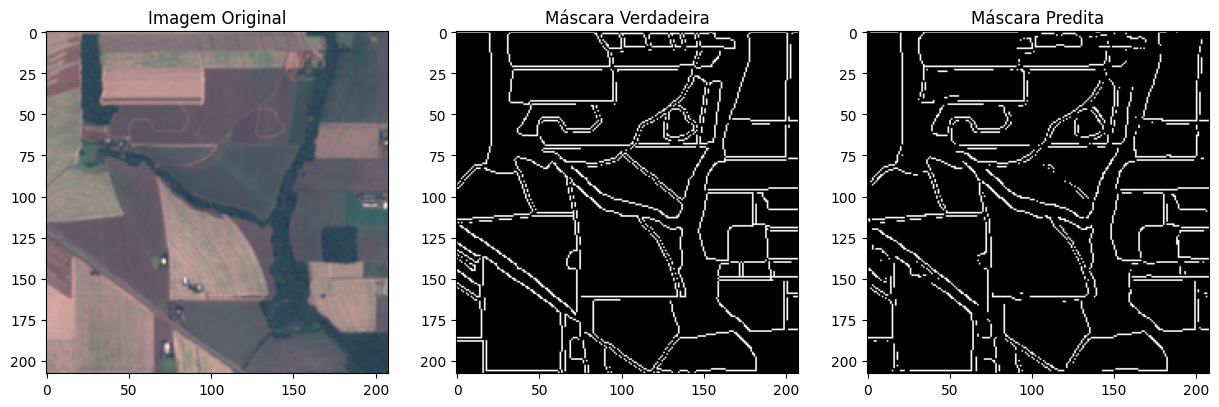

In [ ]:
index = np.random.randint(0, len(X_test))
VisualizeResults(X_test[index], y_test_edge[index], unet_predict_edges)

#### Carregamento do modelo de segmentação com bordas

In [ ]:
file_id_model = '1vYpnaUFthxMMTcld8TvP7d82jHcucVUA'

download_url = f"https://drive.google.com/uc?id={file_id_model}"

gdown.download(download_url, 'UnetPropriaBordas.h5', quiet=False)

# uso para segmentação utilizando o quarto canal
model_path = "/content/UnetPropriaBordas.h5"
saved_edge_model = load_model(model_path)

Downloading...
From: https://drive.google.com/uc?id=1vYpnaUFthxMMTcld8TvP7d82jHcucVUA
To: /content/UnetPropriaBordas.h5
100%|██████████| 18.5M/18.5M [00:00<00:00, 37.2MB/s]


### T4 GPU

#### Treinamento do modelo

In [ ]:
unet = UNet((208, 208, 3), X_train, X_test, y_train, y_test, n_filters=16)
unet.unet_compiled()
t4_time_train_start = time.time()
t4_mem_before = memory_usage_psutil()
results = unet.train_model()
t4_mem_after = memory_usage_psutil()
t4_mem_usage = t4_mem_after - t4_mem_before
t4_time_train_final = time.time() - t4_time_train_start

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 208, 208, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 208, 208, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 208, 208, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 208, 208, 16)         64        ['conv2d_1[0][0]']            
 Normalization)                                                                               

KeyboardInterrupt: 

In [ ]:
unet.plot_results(results)

In [ ]:
## Save model
unet.model.save("/content/drive/MyDrive/Models/UnetPropria_imagens_geradas.h5")

####Carregamento do modelo

In [ ]:
file_id_model = '1i0MV4wANQKN6D10rLfvNCKeBq8Kuo5t5'

download_url = f"https://drive.google.com/uc?id={file_id_model}"

gdown.download(download_url, 'UnetPropria_imagens_geradas.h5', quiet=False)

model_path = "/content/UnetPropria_imagens_geradas.h5"
saved_model = load_model(model_path)

Downloading...
From: https://drive.google.com/uc?id=1i0MV4wANQKN6D10rLfvNCKeBq8Kuo5t5
To: /content/UnetPropria_saturada.h5
100%|██████████| 18.5M/18.5M [00:00<00:00, 86.0MB/s]


#### Predição do modelo

1/1 [==============================] - 0s 22ms/step
(208, 208, 1) (208, 208, 1)
| Métrica             |         Valor |
|---------------------+---------------|
| Acurácia            |     0.891064  |
| True Positives      | 14202         |
| True Negatives      | 24349         |
| False Positives     |  2287         |
| False Negatives     |  2426         |
| Number of Positives | 16628         |
| Number of Negatives | 26636         |
| True Positive Rate  |     0.854102  |
| True Negative Rate  |     0.914139  |
| False Positive Rate |     0.0858612 |
| False Negative Rate |     0.145898  |
| IoU                 |     0.750833  |
| Precisão            |     0.861301  |
| Recall              |     0.854102  |
| F1 Score            |     0.857686  |
| Coverage            |     0.685244  |


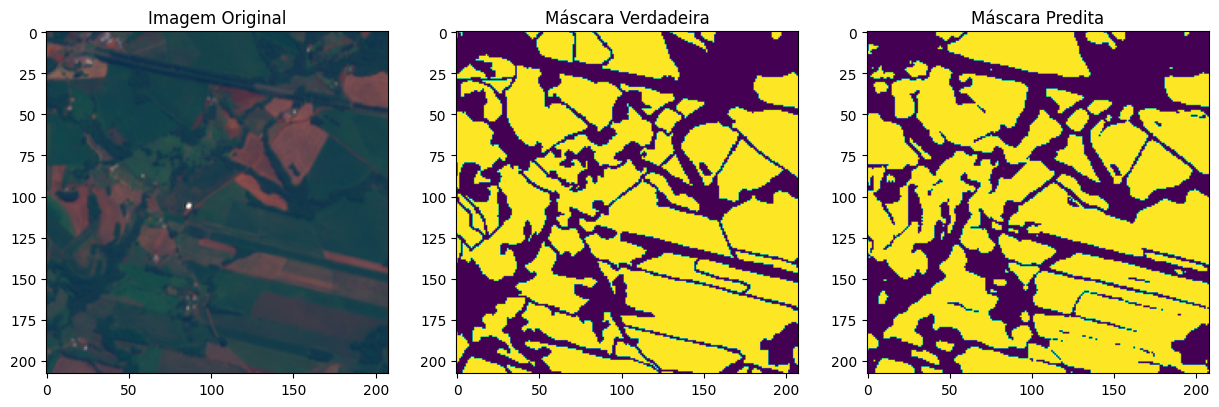

In [ ]:
index = np.random.randint(0, len(X_test))
t4_inference_start = time.time()
VisualizeResults(X_test[index], y_test[index], saved_model)
t4_inference_final = time.time() - t4_inference_start

#### Predição do modelo com bordas

1/1 [==============================] - 0s 21ms/step
(208, 208, 1) (208, 208, 1)
| Métrica             |         Valor |
|---------------------+---------------|
| Acurácia            |     0.941083  |
| True Positives      | 13674         |
| True Negatives      | 27041         |
| False Positives     |  1290         |
| False Negatives     |  1259         |
| Number of Positives | 14933         |
| Number of Negatives | 28331         |
| True Positive Rate  |     0.91569   |
| True Negative Rate  |     0.954467  |
| False Positive Rate |     0.0455332 |
| False Negative Rate |     0.0843099 |
| IoU                 |     0.842877  |
| Precisão            |     0.913793  |
| Recall              |     0.91569   |
| F1 Score            |     0.914741  |
| Coverage            |     0.847679  |


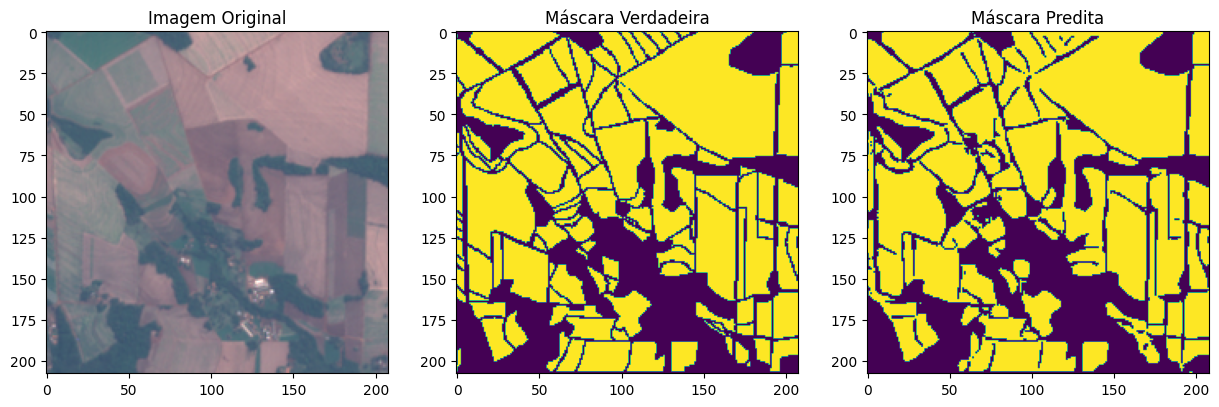

In [ ]:
index = np.random.randint(0, len(X_test))
t4_inference_start = time.time()
VisualizeResultsWithBorders(X_test[index], y_test[index], unet_predict_edges, saved_edge_model)
t4_inference_final = time.time() - t4_inference_start

### CPU

#### Treinamento do modelo

In [ ]:
unet = UNet((208, 208, 3), X_train, X_test, y_train, y_test, n_filters=16)
unet.unet_compiled()
cpu_time_train_start = time.time()
results = unet.train_model()
cpu_time_train_final = time.time() - cpu_time_train_start

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 208, 208, 3)]        0         []                            
                                                                                                  
 conv2d_112 (Conv2D)         (None, 208, 208, 16)         448       ['input_8[0][0]']             
                                                                                                  
 conv2d_113 (Conv2D)         (None, 208, 208, 16)         2320      ['conv2d_112[0][0]']          
                                                                                                  
 batch_normalization_28 (Ba  (None, 208, 208, 16)         64        ['conv2d_113[0][0]']          
 tchNormalization)                                                                          

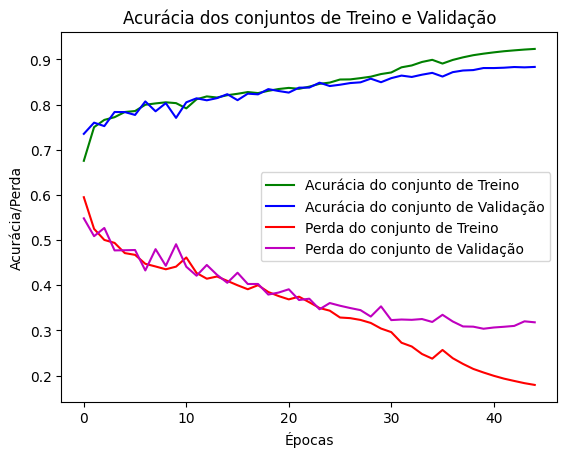

<Figure size 640x480 with 0 Axes>

In [ ]:
unet.plot_results(results)

In [ ]:
## Save model
unet.model.save("/content/drive/MyDrive/Models/UnetPropria_saturada.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


####Carregamento do modelo

In [ ]:
file_id_model = '1i0MV4wANQKN6D10rLfvNCKeBq8Kuo5t5'

download_url = f"https://drive.google.com/uc?id={file_id_model}"

gdown.download(download_url, 'UnetPropria_saturada.h5', quiet=False)

model_path = "/content/UnetPropria_saturada.h5"
saved_model = load_model(model_path)

#### Predição do modelo

1/1 [==============================] - 0s 24ms/step
| Métrica             |         Valor |
|---------------------+---------------|
| Acurácia            |     0.876341  |
| True Positives      |  6198         |
| True Negatives      | 31716         |
| False Positives     |  1894         |
| False Negatives     |  3456         |
| Number of Positives |  9654         |
| Number of Negatives | 33610         |
| True Positive Rate  |     0.642014  |
| True Negative Rate  |     0.943648  |
| False Positive Rate |     0.0563523 |
| False Negative Rate |     0.357986  |
| IoU                 |     0.536716  |
| Precisão            |     0.765942  |
| Recall              |     0.642014  |
| F1 Score            |     0.698524  |
| Coverage            |     0.53858   |


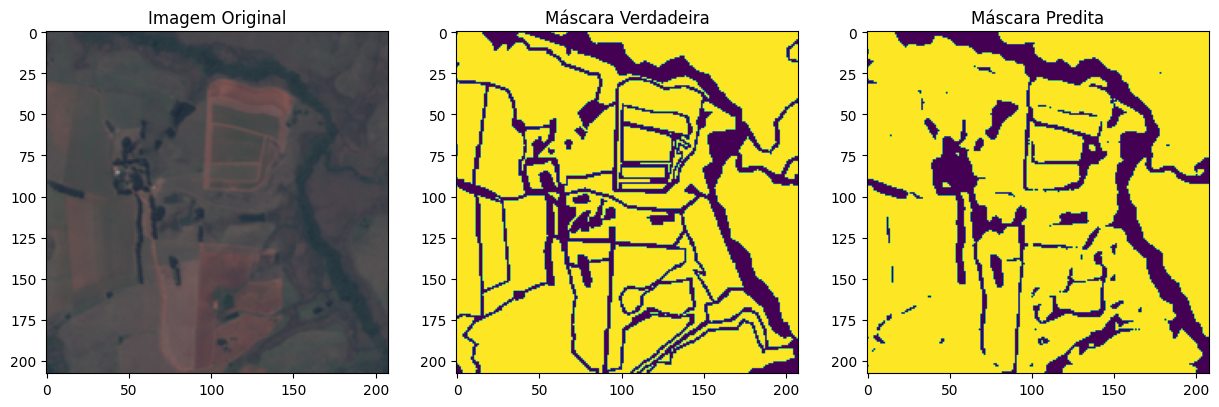

In [ ]:
index = np.random.randint(0, len(X_test))
cpu_inference_start = time.time()
VisualizeResults(X_test[index], y_test[index], saved_model)
cpu_inference_final = time.time() - cpu_inference_start

#### Predição do modelo com bordas

In [ ]:
index = np.random.randint(0, len(X_test))
cpu_inference_start = time.time()
VisualizeResultsWithBorders(X_test[index], y_test[index], unet_predict_edges, saved_edge_model)
cpu_inference_final = time.time() - cpu_inference_start

### A100 GPU

#### Treinamento do modelo

In [ ]:
unet = UNet((208, 208, 3), X_train, X_test, y_train, y_test, n_filters=16)
unet.unet_compiled()
a100_time_train_start = time.time()
a100_mem_before = memory_usage_psutil()
results = unet.train_model()
a100_mem_after = memory_usage_psutil()
a100_mem_usage = a100_mem_after - a100_mem_before
a100_time_train_final = time.time() - a100_time_train_start

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 208, 208, 3)]        0         []                            
                                                                                                  
 conv2d_128 (Conv2D)         (None, 208, 208, 16)         448       ['input_9[0][0]']             
                                                                                                  
 conv2d_129 (Conv2D)         (None, 208, 208, 16)         2320      ['conv2d_128[0][0]']          
                                                                                                  
 batch_normalization_32 (Ba  (None, 208, 208, 16)         64        ['conv2d_129[0][0]']          
 tchNormalization)                                                                          

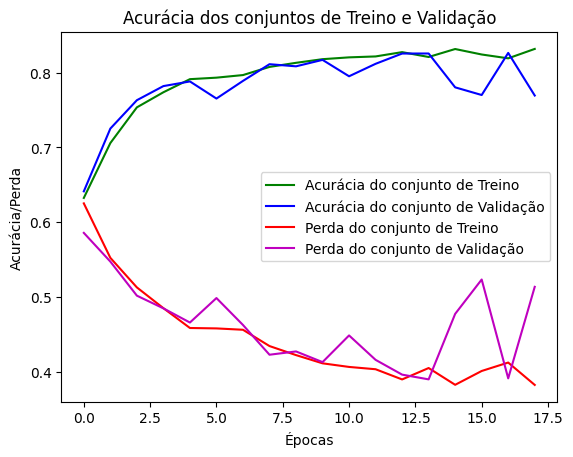

<Figure size 640x480 with 0 Axes>

In [ ]:
unet.plot_results(results)

In [ ]:
## Save model
unet.model.save("/content/drive/MyDrive/Models/UnetPropria_saturada.h5")

####Carregamento do modelo

In [ ]:
file_id_model = '1i0MV4wANQKN6D10rLfvNCKeBq8Kuo5t5'

download_url = f"https://drive.google.com/uc?id={file_id_model}"

gdown.download(download_url, 'UnetPropria_saturada.h5', quiet=False)

model_path = "/content/UnetPropria_saturada.h5"
saved_model = load_model(model_path)

#### Predição do Modelo

1/1 [==============================] - 0s 249ms/step
| Métrica             |        Valor |
|---------------------+--------------|
| Acurácia            |     0.853435 |
| True Positives      | 13732        |
| True Negatives      | 23191        |
| False Positives     |  3321        |
| False Negatives     |  3020        |
| Number of Positives | 16752        |
| Number of Negatives | 26512        |
| True Positive Rate  |     0.819723 |
| True Negative Rate  |     0.874736 |
| False Positive Rate |     0.125264 |
| False Negative Rate |     0.180277 |
| IoU                 |     0.684103 |
| Precisão            |     0.805254 |
| Recall              |     0.819723 |
| F1 Score            |     0.812424 |
| Coverage            |     0.616658 |


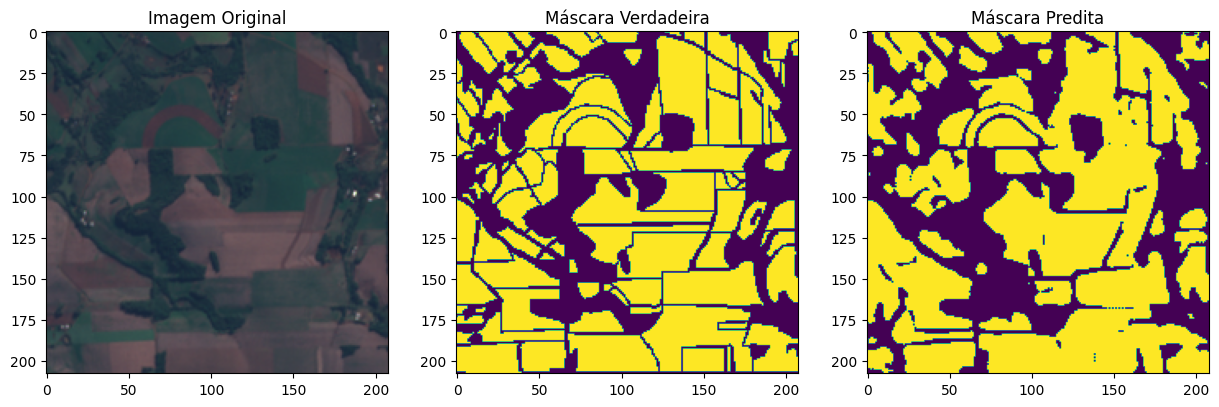

In [ ]:
index = np.random.randint(0, len(X_test))
a100_inference_start = time.time()
VisualizeResults(X_test[index], y_test[index], saved_model)
a100_inference_final = time.time() - a100_inference_start

#### Predição do modelo com bordas

In [ ]:
index = np.random.randint(0, len(X_test))
a100_inference_start = time.time()
VisualizeResultsWithBorders(X_test[index], y_test[index], unet_predict_edges, saved_edge_model)
a100_inference_final = time.time() - a100_inference_start

### Tempos de inferencia e treinamento
As células abaixo mostram o tempo de treinamento, predição e o uso de memória para cada tipo de ambiente de execução. É possível notar que a A100 GPU é consideravelmente mais eficiente que as outras.

#### T4 GPU

In [ ]:
print("Tempo de treinamento (em segundos) usando o T4 GPU: ", t4_time_train_final)
print("Tempo de inferência (em segundos) de 1 predição usando o T4 GPU: ", t4_inference_final)
print("Memória utilizada usando o A100 GPU: ", t4_mem_usage, "MB")

Tempo de treinamento (em segundos) usando o T4 GPU:  57.99918293952942
Tempo de inferência (em segundos) de 1 predição usando o T4 GPU:  0.2440352439880371
Memória utilizada usando o A100 GPU:  130.3984375 MB


#### CPU

*O tempo de processamento da CPU apresentou uma demora relevante. Isso se deve ao fato da CPU ser executada de forma sequencial e a GPU de forma paralela.*

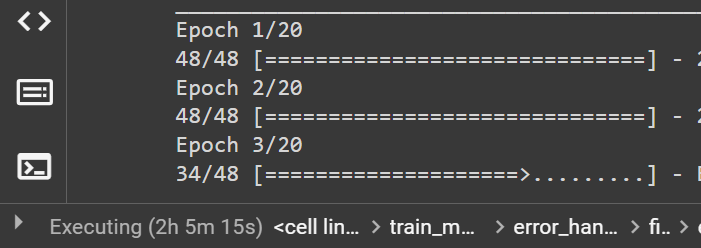

#### A100 GPU

In [ ]:
print("Tempo de treinamento usando o A100 GPU: ", a100_time_train_final)
print("Tempo de inferência de 1 predição usando o A100 GPU: ", a100_inference_final)
print("Memória utilizada usando o A100 GPU: ", a100_mem_usage, "MB")

Tempo de treinamento usando o A100 GPU:  51.999560594558716
Tempo de inferência de 1 predição usando o A100 GPU:  0.488588809967041
Memória utilizada usando o A100 GPU:  136.79296875 MB
